<a href="https://colab.research.google.com/github/PriankaKibria17/Spotify_Analysis/blob/main/Proj2_Pt_4_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This data contains songs that have been played most frequently and have reached the Top 200 Weekly Global charts of spotify.

source: https://www.kaggle.com/datasets/sashankpillai/spotify-top-200-charts-20202021/code 

In [68]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [69]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.datasets import fetch_openml
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [70]:
spotify = pd.read_csv('/content/drive/MyDrive/data/spotify_dataset.csv')
spotify.head()

,Index,Highest Charting Position,Number of Times Charted,Week of Highest Charting,Song Name,Streams,Artist,Artist Followers,Song ID,Genre,...,Danceability,Energy,Loudness,Speechiness,Acousticness,Liveness,Tempo,Duration (ms),Valence,Chord
0,1,1,8,2021-07-23--2021-07-30,Beggin',"48,633,449",Måneskin,3377762,3Wrjm47oTz2sjIgck11l5e,"['indie rock italiano', 'italian pop']",...,0.714,0.8,-4.808,0.0504,0.127,0.359,134.002,211560,0.589,B
1,2,2,3,2021-07-23--2021-07-30,STAY (with Justin Bieber),"47,248,719",The Kid LAROI,2230022,5HCyWlXZPP0y6Gqq8TgA20,['australian hip hop'],...,0.591,0.764,-5.484,0.0483,0.0383,0.103,169.928,141806,0.478,C#/Db
2,3,1,11,2021-06-25--2021-07-02,good 4 u,"40,162,559",Olivia Rodrigo,6266514,4ZtFanR9U6ndgddUvNcjcG,['pop'],...,0.563,0.664,-5.044,0.154,0.335,0.0849,166.928,178147,0.688,A
3,4,3,5,2021-07-02--2021-07-09,Bad Habits,"37,799,456",Ed Sheeran,83293380,6PQ88X9TkUIAUIZJHW2upE,"['pop', 'uk pop']",...,0.808,0.897,-3.712,0.0348,0.0469,0.364,126.026,231041,0.591,B
4,5,5,1,2021-07-23--2021-07-30,INDUSTRY BABY (feat. Jack Harlow),"33,948,454",Lil Nas X,5473565,27NovPIUIRrOZoCHxABJwK,"['lgbtq+ hip hop', 'pop rap']",...,0.736,0.704,-7.409,0.0615,0.0203,0.0501,149.995,212000,0.894,D#/Eb


In [71]:
# There are 3 integer columns and the rest are objects. The data types of some of the numeric columns will have to be changed.
spotify.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1556 entries, 0 to 1555
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Index                      1556 non-null   int64 
 1   Highest Charting Position  1556 non-null   int64 
 2   Number of Times Charted    1556 non-null   int64 
 3   Week of Highest Charting   1556 non-null   object
 4   Song Name                  1556 non-null   object
 5   Streams                    1556 non-null   object
 6   Artist                     1556 non-null   object
 7   Artist Followers           1556 non-null   object
 8   Song ID                    1556 non-null   object
 9   Genre                      1556 non-null   object
 10  Release Date               1556 non-null   object
 11  Weeks Charted              1556 non-null   object
 12  Popularity                 1556 non-null   object
 13  Danceability               1556 non-null   object
 14  Energy  

In [72]:
#No duplicates
spotify.duplicated().sum()

0

In [73]:
#Dropping unneccessary columns with either no distributing values or unique values that are not needed
spotify.drop(columns = ['Index', 'Song ID', 'Chord', 'Week of Highest Charting', 'Weeks Charted', 'Release Date', 'Song Name', 'Artist', 'Genre'], inplace = True)

Changing the data type for:

- streams
- aritst followers
- danceability
- energy
- loudness
- speechiness
- acousticness
- liveness
- tempo
- duration
- valence

Changing the object columns that are numeric.

In [14]:
#encoding genre

#le = LabelEncoder()
#spotify['Genre'] = le.fit_transform(spotify['Genre'])
#spotify.head()

,HighestChartingPosition,NumberofTimesCharted,Streams,ArtistFollowers,Genre,Popularity,Danceability,Energy,Loudness,Speechiness,Acousticness,Liveness,Tempo,Duration(ms),Valence
0,1,8,48633449,3377762,278,100,0.714,0.8,-4.808,0.0504,0.127,0.359,134.002,211560,0.589
1,2,3,47248719,2230022,65,99,0.591,0.764,-5.484,0.0483,0.0383,0.103,169.928,141806,0.478
2,1,11,40162559,6266514,366,99,0.563,0.664,-5.044,0.154,0.335,0.0849,166.928,178147,0.688
3,3,5,37799456,83293380,365,98,0.808,0.897,-3.712,0.0348,0.0469,0.364,126.026,231041,0.591
4,5,1,33948454,5473565,314,96,0.736,0.704,-7.409,0.0615,0.0203,0.0501,149.995,212000,0.894


In [74]:
#removing the the commas in streams
#Code ref: Stackedoverflow
spotify.Streams = spotify.Streams.apply(lambda Streams : Streams.replace(',', ''))

In [75]:
#removing commas, 
spotify.replace(',','', regex=True, inplace=True)
spotify.replace("'",'', regex=True, inplace=True)
spotify.replace(" '' ",'', regex=True, inplace=True)

In [76]:
#renaming column names to remove the space
spotify.rename(columns = {'Highest Charting Position':'HighestChartingPosition'}, inplace = True)
spotify.rename(columns = {'Number of Times Charted':'NumberofTimesCharted'}, inplace = True)
spotify.rename(columns = {'Artist Followers':'ArtistFollowers'}, inplace = True)
spotify.rename(columns = {'Duration (ms)':'Duration(ms)'}, inplace = True)

In [77]:
spotify['Streams'] = spotify['Streams'].astype('int')

In [78]:
#converting datatypes
Allobjectcolumns = ['ArtistFollowers', 'Danceability', 'Energy', 'Loudness', 'Speechiness', 'Acousticness', 'Liveness', 'Tempo', 'Duration(ms)', 'Valence']
#code ref for loop: Stackedoverflow + Kaggle
for each_col in Allobjectcolumns:
  spotify[each_col] = pd.to_numeric(spotify[each_col], errors = 'coerce')

In [79]:
#identifying null columns
spotify.isnull().sum()

HighestChartingPosition     0
NumberofTimesCharted        0
Streams                     0
ArtistFollowers            11
Popularity                  0
Danceability               11
Energy                     11
Loudness                   11
Speechiness                11
Acousticness               11
Liveness                   11
Tempo                      11
Duration(ms)               11
Valence                    11
dtype: int64

In [80]:
#removing all null values since I the numeric columns are imperative
spotify = spotify.dropna()

In [81]:
spotify.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1545 entries, 0 to 1555
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   HighestChartingPosition  1545 non-null   int64  
 1   NumberofTimesCharted     1545 non-null   int64  
 2   Streams                  1545 non-null   int64  
 3   ArtistFollowers          1545 non-null   float64
 4   Popularity               1545 non-null   object 
 5   Danceability             1545 non-null   float64
 6   Energy                   1545 non-null   float64
 7   Loudness                 1545 non-null   float64
 8   Speechiness              1545 non-null   float64
 9   Acousticness             1545 non-null   float64
 10  Liveness                 1545 non-null   float64
 11  Tempo                    1545 non-null   float64
 12  Duration(ms)             1545 non-null   float64
 13  Valence                  1545 non-null   float64
dtypes: float64(10), int64(3)

In [82]:
#the target is streams
X = spotify.drop(columns = 'Streams')
y = spotify['Streams']

In [85]:
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=25) #test_size = 0.2)

In [86]:
#getting the shape of the data
print('X Train:', X_train.shape) #the X training set contains 1158 data
print('y Train:', y_train.shape) #the y training set contains 387 data
print('X_test:', X_test.shape)#the X testing set contains 1158 data
print('y_test:', y_test.shape) #the y testing set contains 387 data

X Train: (1158, 13)
y Train: (1158,)
X_test: (387, 13)
y_test: (387,)


#KMEANS

In [87]:
scaler = StandardScaler()
scaled_df = scaler.fit_transform(spotify)

Text(0, 0.5, 'inertia')

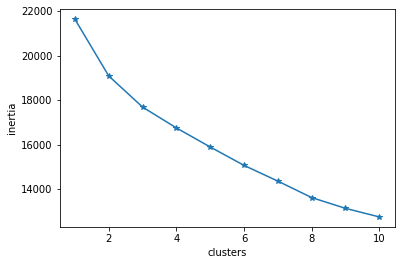

In [88]:
#looking for KMeans

#empty list of intertias
inertias = []

#looping through k values between 1 and 11 and store the inertias in the list
for k in range(1,11):
  kmeans = KMeans(n_clusters=k) 
  kmeans.fit(scaled_df)
  inertias.append(kmeans.inertia_) 
plt.plot(range(1,11), inertias, marker = '*')
plt.xlabel('clusters')
plt.ylabel('inertia')

The "elbow" indicates the optimal cluster would be 2

#Silhouette

Text(0, 0.5, 'Silhouette score')

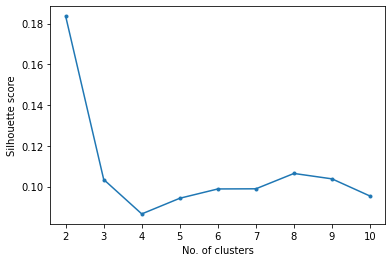

In [89]:
#saving various scores for various clusters of numbers in lists
silhouette_scores = []
for i in range(2,11):
  kmeans = KMeans(n_clusters = i)
  kmeans.fit(scaled_df)
  silhouette_scores.append(silhouette_score(scaled_df, kmeans.labels_))


#visualizing

plt.plot(range(2,11), silhouette_scores, marker = '.')
plt.xlabel('No. of clusters')
plt.ylabel('Silhouette score')

2 is the highest score, therefore it would be most optimal.

In [90]:
#obtaining the sihouette score, fitting kmeans model, and displaying score

kmeans = KMeans(n_clusters = 2)
kmeans.fit(scaled_df)
silhouette_score(scaled_df, kmeans.labels_)

0.18363826197079378

Received a very low score, which is not good.

#Using PCA

In [91]:
#scaling my data as it is required for PCA
scaler = StandardScaler()
scaled_df = scaler.fit_transform(X_train) #fitting

In [92]:
pca = PCA(n_components = .95) #using 95% of my data
pca.fit(scaled_df) #fitting on PCA

PCA(n_components=0.95)

In [93]:
processed = make_pipeline(scaler, pca) #creating my pipeline for PCA & scaler

In [94]:
#obtaining the shape of my data
print('before PCA:', X_train.shape)
print('after PCA:', processed.fit_transform(X_train).shape)
print('reduced by: ', X_train.shape[1] - processed.fit_transform(X_train).shape[1])

before PCA: (1158, 13)
after PCA: (1158, 11)
reduced by:  2


out of the 13 columns 2 were reduced while retaining 95% of the data

#logistic regression

With PCA:

In [102]:
#pipeline for my PCA
transformer = make_pipeline(StandardScaler(), PCA(n_components=.95))

In [103]:
from sklearn.linear_model import LogisticRegression
#instantiating logistic regression
logreg = LogisticRegression()
#modeling and pipeline
logregpipe_ = make_pipeline(transformer, logreg)
logregpipe_.fit(X_train, y_train)

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('standardscaler', StandardScaler()),
                                 ('pca', PCA(n_components=0.95))])),
                ('logisticregression', LogisticRegression())])

In [104]:
#testing the model and obtaining scores 
print('Training accuracy:', logregpipe_.score(X_train, y_train))
print('Testing accuracy:', logregpipe_.score(X_test, y_test))


Training accuracy: 0.9490500863557858
Testing accuracy: 0.0


The logistic regression with a PCA has a score of 0.94 with 95% of variance. Which is significantly higher than the KMeans model.

Without PCA:

In [109]:
#instantiating logistic regression
logreg = LogisticRegression()
#modeling and pipeline
logregpipe_ = make_pipeline(StandardScaler(), logreg)
logregpipe_.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression())])

In [124]:
#testing the model and obtaining scores 
logregtrain_output = print('Training accuracy:', logregpipe_.score(X_train, y_train))
print('Testing accuracy:', logregpipe_.score(X_test, y_test))

Training accuracy: 0.9879101899827288
Testing accuracy: 0.0


A better score seems to be conducted without a PCA for the logistic regression model. It scored better than the LR model with a PCA.

#KNN w/PCA

In [105]:
#instantianing KNN
knn = KNeighborsClassifier()
#modeling
KNN_pipe = make_pipeline(scaler, pca, knn)
#fitting
KNN_pipe.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=0.95)),
                ('kneighborsclassifier', KNeighborsClassifier())])

In [106]:
#testing the model and obtaining scores 
print('Training accuracy:', KNN_pipe.score(X_train, y_train))
print('Testing accuracy:', KNN_pipe.score(X_test, y_test))

Training accuracy: 0.18393782383419688
Testing accuracy: 0.0


KNN is receiving a very low score.

KNN without PCA

In [111]:
knn = KNeighborsClassifier()
KNN_pipe = make_pipeline(scaler, knn)
KNN_pipe.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('kneighborsclassifier', KNeighborsClassifier())])

In [112]:
print('Training accuracy:', KNN_pipe.score(X_train, y_train))
print('Testing accuracy:', KNN_pipe.score(X_test, y_test))

Training accuracy: 0.18998272884283246
Testing accuracy: 0.0


The score remains extremely low even without PCA.

#Linear regression

In [113]:
from sklearn.linear_model import LinearRegression

With PCA:

In [115]:
#instantiating my model
linreg = LinearRegression()
linreg_pipe = make_pipeline(scaler, pca, linreg) #creating my linreg pipeline
linreg_pipe.fit(X_train, y_train) #fitting my model

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=0.95)),
                ('linearregression', LinearRegression())])

In [116]:
#testing the model and obtaining scores 
print('Training accuracy:', linreg_pipe.score(X_train, y_train))
print('Testing accuracy:', linreg_pipe.score(X_test, y_test))

Training accuracy: 0.16592114659779855
Testing accuracy: 0.11571676362065952


The linear regression model w/PCA did not perform good as the scores are very low.

Without PCA:

In [117]:
linreg = LinearRegression()
linreg_pipe = make_pipeline(scaler, linreg)
linreg_pipe.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearregression', LinearRegression())])

In [118]:
print('Training accuracy:', linreg_pipe.score(X_train, y_train))
print('Testing accuracy:', linreg_pipe.score(X_test, y_test))

Training accuracy: 0.1666819894170397
Testing accuracy: 0.11021787508223613


Not much of a differential score than the lingreg w/a PCA. The scores remain very low.

#Random Forrest

With PCA:

In [119]:
from sklearn.ensemble import RandomForestRegressor

In [120]:
#instantiating random forrest
rf = RandomForestRegressor()
rf_pipe = make_pipeline(scaler, pca, rf)#creating a pipeline
rf_pipe.fit(X_train, y_train) #fitting

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=0.95)),
                ('randomforestregressor', RandomForestRegressor())])

In [121]:
#obtaining score for my model
print('Training accuracy:', rf_pipe.score(X_train, y_train))
print('Testing accuracy:', rf_pipe.score(X_test, y_test))

Training accuracy: 0.9048820668318618
Testing accuracy: 0.29045111948431046


Without PCA:

In [122]:
#instantiating random forrest
rf = RandomForestRegressor()
rf_pipe = make_pipeline(scaler, rf)#creating a pipeline
rf_pipe.fit(X_train, y_train) #fitting

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestregressor', RandomForestRegressor())])

In [123]:
#obtaining score for my model
print('Training accuracy:', rf_pipe.score(X_train, y_train))
print('Testing accuracy:', rf_pipe.score(X_test, y_test))

Training accuracy: 0.9763793466688971
Testing accuracy: 0.8331243767892835


#Findings and choice of production model:

*   KMeans model with 2 clusters performance: 0.18363826197079378

*   Logistic Regression with PCA: 0.9490500863557858
*   Logistic Regression without PCA: 0.9879101899827288

*   KNN Model with PCA: 0.18393782383419688
*   KNN Model without PCA: 0.18998272884283246

*   LinearRegression with PCA: 

Training: 0.16592114659779855 
Test: 0.11571676362065952

*   LinearRegression without PCA: 

Training: 0.1666819894170397
Testing: 0.11021787508223613

*   Random Forrest with PCA: 

Train: 0.9048820668318618
Test: 0.29045111948431046


*   Random Forrest without PCA:

Train: 0.9763793466688971
Test: 0.8331243767892835


The KMeans, KNN, Linnear regression models would not be useful models as they scored below 60% in the teen number ranges. Their performance was dissatisfactory.

The Logistic regression without PCA performed well with a 0.98% 

#Choice of model: 
In my opinion I would say that the random forrest without PCA performed best as it had a 0.97% training score and 0.83% testing score which is in the higher spectrum of accuracy.






